# Fitting Nonlinear Chromaticity using simulations of the IOTA 8-2 (low tune) lattice

This notebook examines the presence of nonlinear chromaticity in the (Tier 1) IOTA lattice by simulating an array of particles with varying energy spread and evaluating their perturbed trajectories.

**Note**
- This notebook uses an adjusted lattice constructed by Sasha Romanov. It's based on the IOTA 8-2 design but the quads have been changed to reduce the tunes: $\nu_x = 3.8$ and $\nu_y=2.8$

**Actions**
1. Consider an ensemble of particle starting at a fixed non-zero amplitude but with a range of energy offsets (-0.005 to 0.005).
    1. Run many turns through the lattice
    2. Compute the tune of each particle
    3. Plot the particle tune as a function of momentum offset
    4. Perform a fit and see what order contributions dominate

## Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import constants
import tables
from mpi4py import MPI

In [3]:
from base_diagnostics import utils
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from base_diagnostics import lfplot
from base_diagnostics import latticework
from base_diagnostics import basic_calcs
from base_diagnostics import pltbunch
from base_diagnostics import elliptic_sp
from base_diagnostics import singleparticle
from base_diagnostics import options

import synergia
import synergia_workflow

## Load options and lattice

In [4]:
#load options for ZC_test
from ZC_test_options import opts

#================== Setting up logger and MPI comunicator ============================
#try:
#if True:
# this is the communicator object that will be used for MPI operations
comm = synergia.utils.Commxx()
myrank = comm.get_rank()
mpisize = comm.get_size()
verbose = opts.verbosity>0

logger = synergia.utils.Logger(0)


if myrank == 0:
    print "my rank is 0"
else:
    print "not rank 0"

my rank is 0


In [5]:
#================== Load the lattice =======================

lattices = {}
dir_66 = '/Users/ncook/radiasoft/ioptics/ioptics/lattices/Iota6-6/'
dir_82 = '/Users/ncook/radiasoft/ioptics/ioptics/lattices/Iota8-2/'

lattices['t1_1IO_66'] = dir_66 + "lattice_1IO_center.madx" #centered t1 6.6 1IO lattice
lattices['t1_1IO_82_uncentered'] = dir_82 + "lattice_1IO.madx" #uncentered tier1 8.2 lattice
lattices['t1_1IO_82'] = dir_82 + "lattice_1IO_center.madx" #this is the new tier1 8.2 (zero current) lattice
lattices['t1_1IO_82_dQ_1'] = dir_82 + "lattice_1IO_dQ_1.madx" #t1 8.2 lattice adjusted for dQ = -0.1
lattices['t1_1IO_82_dQ'] = dir_82 + "lattice_1IO_dQ_2.madx" #t1 8.2 lattice adjusted for dQ = -0.2
lattices['t1_1IO_82_lowtune'] = dir_82 + "lattice_1IO_lowtune_center.madx" #t1 8.2 lattice with reduced tune

lattices['t3_1IO_66'] = dir_66 + "lattice_1IO_nll_center.madx" #centered t3 6.6 1IO lattice
lattices['t3_1IO_82'] = dir_82 + "lattice_1IO_nll_center.madx" #this is the centerted t3 8.2 lattice


#================= Construct a Python dictionary of lattice stuff ==================
lattice_dict = {}

for keys in lattices.keys():
    lattice_dict[keys] = {} #instantiate sub dictionary
    lattice_dict[keys]['name'] = keys
    lattice_dict[keys]['location'] = lattices[keys]
    lattice_dict[keys]['lattice'] = synergia.lattice.MadX_reader().get_lattice("iota", lattices[keys])

In [7]:
reference_particle = lattice_dict['t1_1IO_82_lowtune']['lattice'].get_reference_particle()
energy = reference_particle.get_total_energy()
opts.beta = reference_particle.get_beta()
opts.gamma = reference_particle.get_gamma()


#================== Setting up the options =======================


nsteps_per_element = 4
dpop = 0
#emittances = [9.74e-7] #reduce emittance by a factor of 10
emit_n = 3.0e-7 #0.3 mm-mrad emittance
emittances = [basic_calcs.calc_geometric_emittance(emit_n,opts.beta,opts.gamma)]
opts.emits = emittances
tval = 0.4
cval = 0.01

outputdir = 't1-82-chromaticity-fit'

opts.output_dir = outputdir
opts.relpath = opts.output_dir
workflow.make_path(outputdir)

nsteps = len(lattice_dict['t1_1IO_82']['lattice'].get_elements())*nsteps_per_element
opts.output_dir = outputdir
opts.relpath = opts.output_dir
opts.steps = nsteps
opts.steps_per_element = nsteps_per_element
workflow.make_path(outputdir)

print "output directory:", opts.output_dir


#==================== Set up space charge solver ==========================

#turn off space charge
requested_stepper = opts.stepper
if opts.spacecharge:
    
    solver = opts.solver
    # space charge only works with the split operator stepper, or soelements 
    if (requested_stepper != "splitoperator") and (requested_stepper != "soelements"):
        requested_stepper = "soelements"
        print "Requested stepper changed to soelements for space charge"

    #force these
    gridx = 32
    gridy = 32
    gridz = 1
    grid = [gridx, gridy, gridz]

    print >>logger, "grid: ", grid

    #opts.comm_divide = None
    if opts.comm_divide:
        sc_comm = synergia.utils.Commxx_divider(opts.comm_divide, False)
    else:
        sc_comm = synergia.utils.Commxx(True)

    #sc_comm = synergia.utils.Commxx(True)
    if solver == "2dopen-hockney":
        coll_operator = synergia.collective.Space_charge_2d_open_hockney(sc_comm, grid)
    elif solver == "3dopen-hockney":
        # full signature for 3d_open_hockney constructor is
        # comm, grid, long_kicks, z_periodic, period, grid_entire_period,
        # nsigma

        coll_operator = synergia.collective.Space_charge_3d_open_hockney(sc_comm, grid, opts.long_kicks, False, 0.0, False, opts.nsigma)
    elif solver == "2dbassetti-erskine":
        coll_operator = synergia.collective.Space_charge_2d_bassetti_erskine()
    else:
        raise RuntimeError, "requested space charge operator %s invalid.  Must be either 2dopen-hockney or 3dopen-hockney"%opts.solver

    print "Using space charge solver ", solver
    print "Grid: ", gridx, " x ", gridy, " x ", gridz

else:
    coll_operator = synergia.simulation.Dummy_collective_operator("stub")
    print "No space charge solver used"

#opts.use_maps = 'none'
#now set element type and construct stepper
#print "use maps for: {}".format(opts.use_maps)
print "requested_stepper: {}".format(requested_stepper)

#for key in lattices.keys():
    
#    current_lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices[key])
#    lattice_dict[key]['lattice'] = latticework.set_lattice_element_type(current_lattice,opts)

        
#================== Setting up the stepper and lattice simulator =======================

opts.map_order = 2

for key in lattices.keys():
    
    current_lattice = lattice_dict[key]['lattice']
    
    for elem in current_lattice.get_elements():

        #apply forced diagnostics
        if elem.get_name() == "sd1r" or elem.get_name() == "sd1l":
            elem.set_string_attribute('no_simplify', 'true')
            elem.set_string_attribute('force_diagnostics', 'true')        
              
        
        #set chef propagation for ALL elements
        elem.set_string_attribute("extractor_type", "chef_propagate")
            

    lattice_dict[key]['stepper'] = synergia.simulation.Independent_stepper(current_lattice, opts.map_order, opts.steps)
    lattice_dict[key]['lattice_simulator'] = lattice_dict[key]['stepper'].get_lattice_simulator()

output directory: t1-82-chromaticity-fit
No space charge solver used
requested_stepper: splitoperator


In [8]:
print "For t1 v6.6 lattice:" + str(lattice_dict['t1_1IO_66']['lattice_simulator'].get_both_tunes())
print "For t1 v8.2 lattice:" + str(lattice_dict['t1_1IO_82']['lattice_simulator'].get_both_tunes())
print "For t1 v8.2 low tune lattice:" + str(lattice_dict['t1_1IO_82_lowtune']['lattice_simulator'].get_both_tunes())

For t1 v6.6 lattice:(0.3000647340300179, 0.30004594618833325)
For t1 v8.2 lattice:(0.3000750787893809, 0.30003554210876365)
For t1 v8.2 low tune lattice:(0.8000074230880753, 0.8000031545610408)


### Verify that the new lattices have the proper equal chromaticities and reasonable lattice functions.

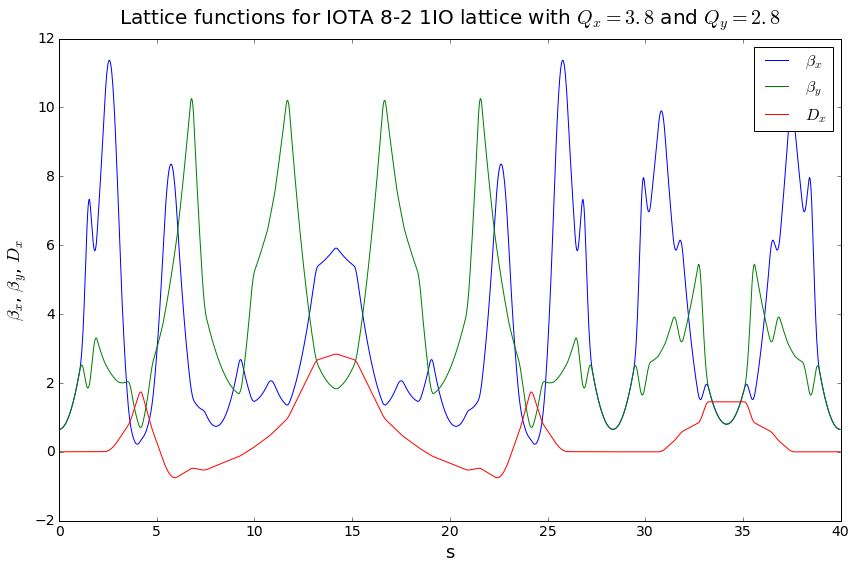

In [10]:
opts.save = False
opts.lattice_name = 'IOTA 8-2 1IO lattice with $Q_x = 3.8$ and $Q_y = 2.8$'
opts.lf_fns = ['beta_x','beta_y','D_x']
opts.lattice = lattice_dict['t1_1IO_82_lowtune']['lattice']
opts.lattice_simulator = lattice_dict['t1_1IO_82_lowtune']['lattice_simulator']
lfplot.plot_sliced_lattice_functions(opts)

We will quickly note the positions of the sextupoles, including the sextupole pairs of interest: sd1r and sd1l.

In [11]:
current_lattice = lattice_dict['t1_1IO_82_lowtune']['lattice']

for elem in current_lattice.get_elements():
    if elem.get_type() == 'sextupole':
        print "{}:{}".format(elem.get_name(),elem.get_double_attributes())

sc1r:{'k2': 0.0, 'at': 3.8980382860000002, 'l': 0.1}
sc2r:{'k2': 0.0, 'at': 4.463038287, 'l': 0.1}
sd1r:{'k2': 0.0, 'at': 7.128576567, 'l': 0.1}
se1r:{'k2': 0.0, 'at': 13.382595717, 'l': 0.1}
se2r:{'k2': 0.0, 'at': 13.945095717, 'l': 0.1}
se2l:{'k2': 0.0, 'at': 14.400095717000001, 'l': 0.1}
se1l:{'k2': 0.0, 'at': 14.962595717000001, 'l': 0.1}
sd1l:{'k2': 0.0, 'at': 21.216614857000003, 'l': 0.1}
sc2l:{'k2': 0.0, 'at': 23.882153146999997, 'l': 0.1}
sc1l:{'k2': 0.0, 'at': 24.447153147, 'l': 0.1}
sa1l:{'k2': 0.0, 'at': 32.286710567, 'l': 0.1}
sa1r:{'k2': 0.0, 'at': 36.026710567, 'l': 0.1}


In [12]:
#construct the beta functions for the adjusted lattice
lfs = lfplot.get_sliced_lf_fns(lattice_dict['t1_1IO_82_lowtune']['lattice'],lattice_dict['t1_1IO_82_lowtune']['lattice_simulator'])
ss = np.array([lfd['s'] for lfd in lfs])
lf_betx = np.array([lfd['beta_x'] for lfd in lfs])
lf_dispx = np.array([lfd['D_x'] for lfd in lfs])
lf_bety = np.array([lfd['beta_y'] for lfd in lfs])

lf_Dispx = lambda s: np.interp(s,ss,lf_dispx)
lf_Betx = lambda s: np.interp(s,ss,lf_betx)
lf_Bety = lambda s: np.interp(s,ss,lf_bety)

i_lf_Betx = lambda s: 1./np.interp(s,ss,lf_betx)
i_lf_Bety = lambda s: 1./np.interp(s,ss,lf_bety)


print "Dispersion at 1st sextupole placement: {}".format(lf_Dispx(7.128576567))
print "Dispersion at 2nd sextupole placement: {}".format(lf_Dispx(21.216614857000003))

Dispersion at 1st sextupole placement: -0.500426951246
Dispersion at 2nd sextupole placement: -0.500426916033


In [14]:
print lattice_dict['t1_1IO_82_lowtune']['lattice_simulator'].get_horizontal_chromaticity()
print lattice_dict['t1_1IO_82_lowtune']['lattice_simulator'].get_vertical_chromaticity()

-8.19282359286
-7.11721286812


It should be noted that this lattice does not have equal chromaticity in each plane, nor equal tune in each plane.

## Set the lattice and generate bunch, etc.

We want to run without the nonlinear element here, so we should choose the correct lattice!

We also want to generate a simple bunch with particles of the same amplitude at different energies. In this case we give every particle x = 0.25 mm and y = 0.25 mm.

In [15]:
opts.lattice = lattice_dict['t1_1IO_82_lowtune']['lattice']
opts.lattice_simulator = lattice_dict['t1_1IO_82_lowtune']['lattice_simulator']
opts.stepper = lattice_dict['t1_1IO_82_lowtune']['stepper']

In [16]:
#======================= Now setup the bunch and other related options =====================
tval = 0.1
cval = 0.01
opts.t = tval
opts.c = cval
opts.new_tune = 0.3
opts.lnll = 1.8
opts.nseg = 20
vals = basic_calcs.get_base_nll(opts.lnll, opts.new_tune, opts.t, opts.c)
#specify vals for center of the section
opts.betae = vals[3]
opts.alphae = 0 #fixed 0 alpha for center
opts.beta0 = vals[3]

n_macro = 201
opts.dpops = (np.arange(0,n_macro)-100)*0.01*0.01 #values from -1% to 1% energy spread, seperated by 0.01% -> 201 total values
opts.macro_particles = len(opts.dpops)
bunch_length = opts.lattice.get_length() #effective bunch length is iota lattice length


#coordinates -> (0,0,0.001,0) -> x = 0, y = 1 mm
bunch = np.zeros((opts.macro_particles,7))
bunch[:,0] = 0.00025*np.ones(opts.macro_particles)
bunch[:,2] = 0.00025*np.ones(opts.macro_particles)
bunch[:,4] = bunch_length*(np.random.random(len(bunch)) -0.5) #center at 0
bunch[:,5] = opts.dpops
bunch[:,6] = np.asarray(range(opts.macro_particles))

bunch_name = '82_2ndOrder_LowTune_Espread_mixed_small.txt'
np.savetxt(bunch_name,bunch)         #write the bunch to a text file

bucket_length = bunch_length
particles_file = bunch_name
myBunch = read_bunch.read_bunch(particles_file, reference_particle, opts.real_particles, bucket_length, comm)

Loading Synergia particles from txt file:  82_2ndOrder_LowTune_Espread_mixed_small.txt
Read  201  particles


/usr/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


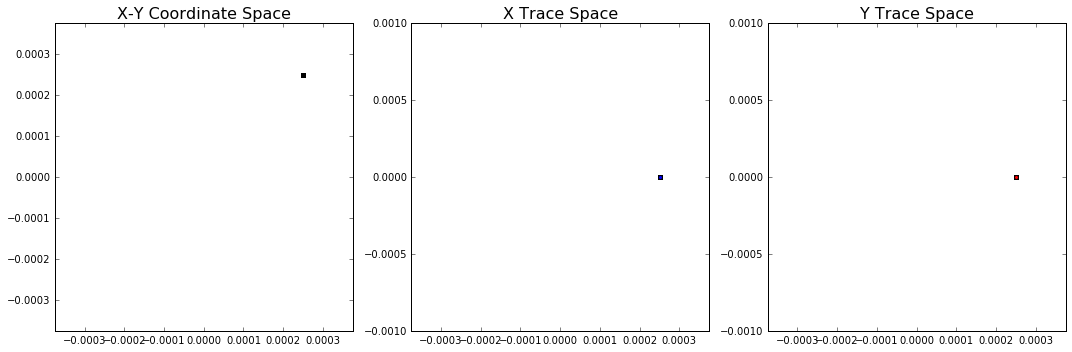

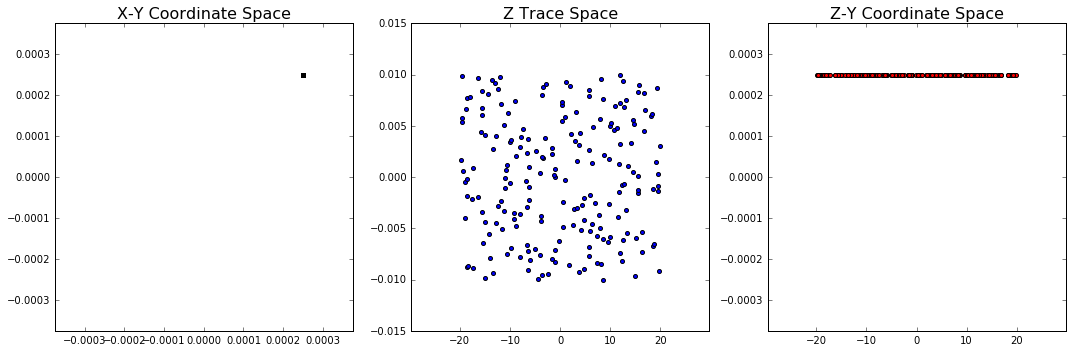

In [17]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [80]:
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#add forced particle diagnostics
bunch_simulator.add_per_forced_diagnostics_step(synergia.bunch.Diagnostics_particles("forced_part.h5",0,0, opts.output_dir))

#particle diagnostics - PER TURN
opts.turnsPerDiag = 1
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag, opts.turnsPerDiag)

In [16]:
opts.turns = 1024
opts.checkpointperiod = 20
opts.maxturns = opts.turns+1

propagator = synergia.simulation.Propagator(opts.stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

workflow.cleanup(opts.output_dir)

## Analysis - Compute the tune for each particle, correlate with initial energy deviation

In [20]:
opts.tune = 0.3 #tune through NL drift
opts.Ch = lattice_dict['t1_1IO_82_lowtune']['lattice_simulator'].get_horizontal_chromaticity()
opts.full_xtune = 3. + lattice_dict['t1_1IO_82_lowtune']['lattice_simulator'].get_horizontal_tune()
opts.full_ytune = 2. + lattice_dict['t1_1IO_82_lowtune']['lattice_simulator'].get_horizontal_tune()

We can see from the Poincare plot below of the x-px phase space that the particles are dramatically perturbed, suggestive of nonlinear dispersive effects. Nonetheless we should be able to compute the tune for the majority of the particles regardless of our capacity to normalize the particle phase space.

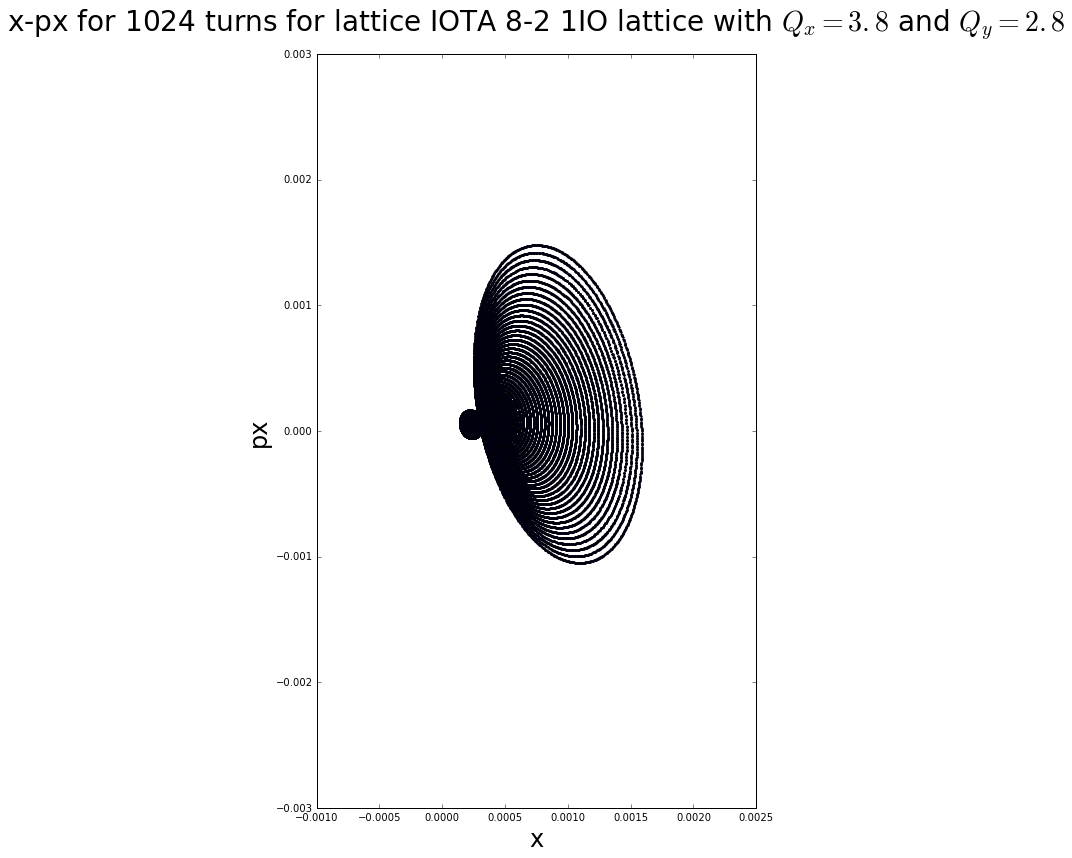

In [32]:
opts.lost = None
opts.plots = ['x','px']
opts.hcoord = opts.plots[0]
opts.vcoord = opts.plots[1]
opts.scale = 2
opts.num = 50
opts.plot_lost = False
opts.save = True
elliptic_sp.toy_plot_Poincare(opts)

In the y-py phase space, we notice much cleaner behavior, another indicator that nonlinear dispersion is strongly affecting the particle orbits in the horizontal plane.

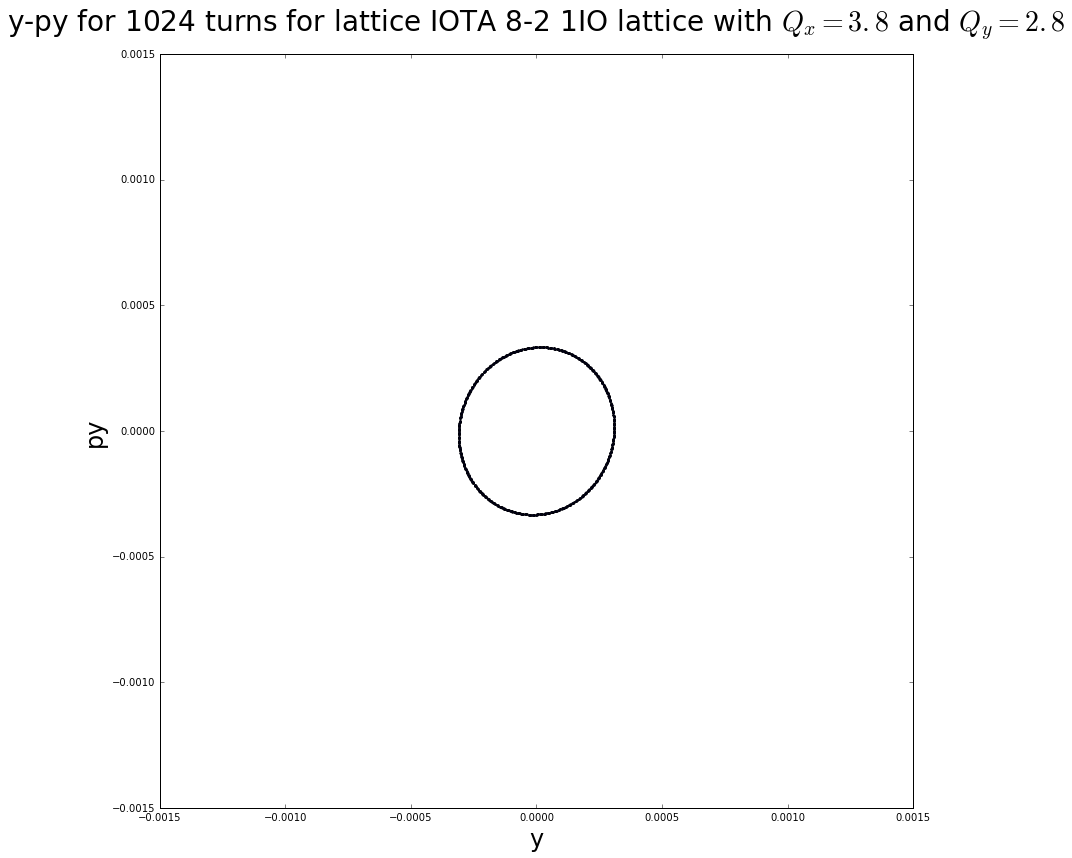

In [33]:
opts.lost = None
opts.plots = ['y','py']
opts.hcoord = opts.plots[0]
opts.vcoord = opts.plots[1]
opts.scale = 2
opts.num = 1
opts.plot_lost = False
opts.save = True
elliptic_sp.toy_plot_Poincare(opts)

## Look at the variation in tunes

Note that because the original fractional tune is > 0.5, we have to take 1- the tune, since our phase advance computation will automatically return a value less than 0.5.

In [22]:
files = elliptic_sp.get_file_list(opts)
files_cut = files[:2]
twiss = elliptic_sp.get_sliced_twiss(lattice_dict['t1_1IO_82_lowtune']['lattice_simulator'])

y_phases = np.ones(n_macro) - elliptic_sp.single_turn_phase_advance(files_cut,twiss,dim='y',nParticles=n_macro,indices=[0,1])
dQy = opts.lattice_simulator.get_vertical_tune() - np.asarray(y_phases)

x_phases = np.ones(n_macro) - elliptic_sp.single_turn_phase_advance(files_cut,twiss,dim='x',nParticles=n_macro,indices=[0,1])
dQx = opts.lattice_simulator.get_vertical_tune() - np.asarray(x_phases)

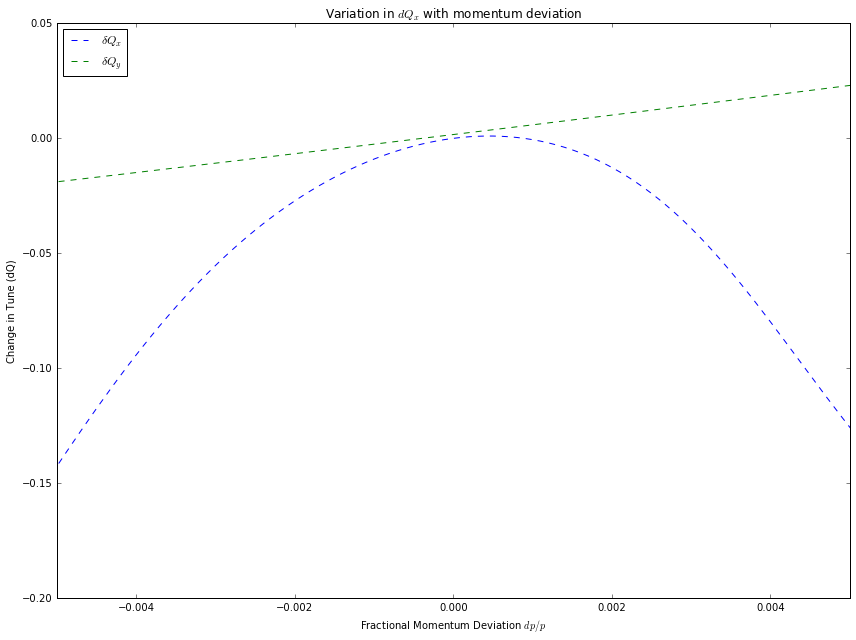

In [23]:
fig = plt.figure(figsize=(12,9))
ax = fig.gca()
ax.plot(opts.dpops,dQx,'--', label = '$\delta Q_x$')
ax.plot(opts.dpops,dQy,'--', label = '$\delta Q_y$')
ax.set_xlim([-0.005,0.005])
ax.set_xlabel('Fractional Momentum Deviation $dp/p$')
ax.set_ylabel('Change in Tune (dQ)')
ax.set_title('Variation in $dQ_x$ with momentum deviation')
ax.legend(scatterpoints=1, loc=2)
plt.show()

We can see that for small momentum deviations, the chromaticity is relatively linear in y, but clearly higher order in x. We will fit a polynomial to each and compute a fit.

In [88]:
## Fit to a polynomial

from scipy.optimize import curve_fit

def poly1(x, a, b):
    '''1st order polynomial for fitting'''
    return a * x + b

def poly2(x, a, b, c):
    '''2nd order polynomial for fitting'''
    return a * x + b*x**2 + c

def poly3(x, a, b, c, d):
    '''Third order polynomial for fitting'''
    return a * x + b*x**2 + c*x**3 + d

def poly4(x, a, b, c, d,e):
    '''Fourth order polynomial for fitting'''
    return a * x + b*x**2 + c*x**3 + d*x**4 + e


def poly5(x, a, b, c, d, e, f):
    '''Fifth order polynomial for fitting'''
    return a * x + b*x**2 + c*x**3 + d*x**4 + e*x**5 + f

def poly7(x, a, b, c, d, e, f, g, h):
    '''Seventh order polynomial for fitting'''
    return a * x + b*x**2 + c*x**3 + d*x**4 + e*x**5 + f*x**6 + g*x**7 + h



popty1, pcovy1 = curve_fit(poly1, opts.dpops, dQy)
print "First Order Fit for dQy"
for ind,val in enumerate(popty1[:-1]):
    print "Order {} term in fit: {}".format(ind+1,val)

popty, pcovy = curve_fit(poly3, opts.dpops, dQy)
print "Third Order Fit for dQy"
for ind,val in enumerate(popty[:-1]):
    print "Order {} term in fit: {}".format(ind+1,val)

print ""
print "Second Order Partial Fit for dQx"
poptx2, pcovx = curve_fit(poly2, opts.dpops[50:151], dQx[50:151])

for ind,val in enumerate(poptx2[:-1]):
    print "Order {} term in fit: {}".format(ind+1,val)    
    
print ""
print "Third Order Fit for dQx"
poptx, pcovx = curve_fit(poly3, opts.dpops[50:151], dQx[50:151])

for ind,val in enumerate(poptx[:-1]):
    print "Order {} term in fit: {}".format(ind+1,val)

print ""
print "Fourth Order Partial Fit for dQx - Remove tails"    
poptx_4, pcovx_4 = curve_fit(poly4, opts.dpops[50:151], dQx[50:151])

for ind,val in enumerate(poptx_4[:-1]):
    print "Order {} term in fit: {}".format(ind+1,val)     
    
print ""
print "Fifth Order Fit for dQx"    
poptx_5, pcovx_5 = curve_fit(poly5, opts.dpops[50:151], dQx[50:151])

for ind,val in enumerate(poptx_5[:-1]):
    print "Order {} term in fit: {}".format(ind+1,val)    

    
print ""
print "7th order Partial Fit for dQx - Accounting for underfitting"
st = 50
en = 151
num_fit = len(opts.dpops[st:en])
poptx_part7, pcovx_part7 = curve_fit(poly7, opts.dpops[st:en], dQx[st:en])

for ind,val in enumerate(poptx_part7[:-1]):
    print "Order {} term in fit: {}".format(ind+1,val)

First Order Fit for dQy
Order 1 term in fit: 4.18060261382
Third Order Fit for dQy
Order 1 term in fit: 4.20344656421
Order 2 term in fit: 15.388165341
Order 3 term in fit: -376.975319249

Second Order Partial Fit for dQx
Order 1 term in fit: 2.16904027364
Order 2 term in fit: -5457.61312049

Third Order Fit for dQx
Order 1 term in fit: 3.6637331235
Order 2 term in fit: -5457.61311828
Order 3 term in fit: -97705.1149406

Fourth Order Partial Fit for dQx - Remove tails
Order 1 term in fit: 3.66373310919
Order 2 term in fit: -5335.90819841
Order 3 term in fit: -97705.1139137
Order 4 term in fit: -5570019.97975

Fifth Order Fit for dQx
Order 1 term in fit: 3.66373313515
Order 2 term in fit: -5335.90806358
Order 3 term in fit: -97705.1154747
Order 4 term in fit: -5570024.89089
Order 5 term in fit: 1.0

7th order Partial Fit for dQx - Accounting for underfitting
Order 1 term in fit: 3.66373311472
Order 2 term in fit: -5335.90815969
Order 3 term in fit: -97705.1142306
Order 4 term in fit: -5

/Users/ncook/.virtualenvs/synergiaenv/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


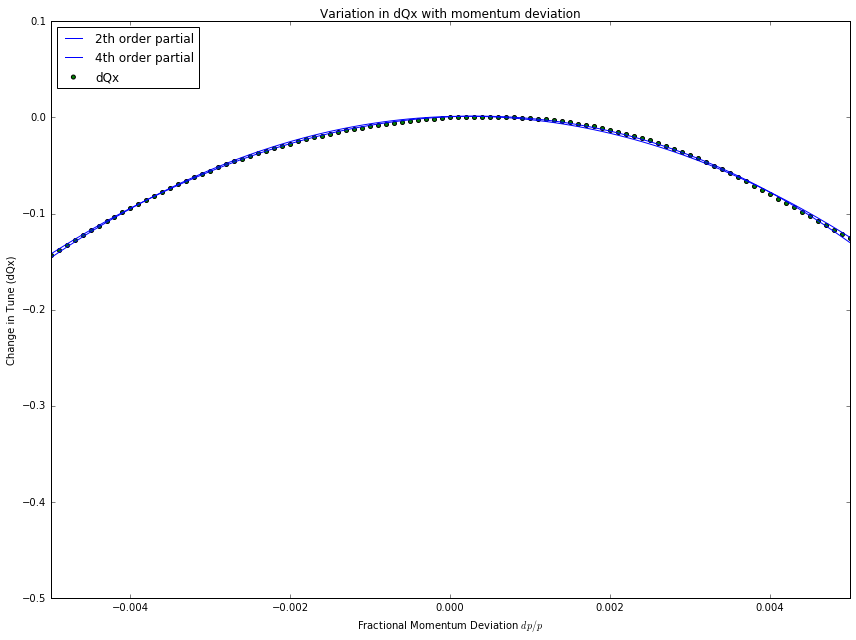

In [89]:
p_poly4x = poly4(opts.dpops[st:en], poptx_4[0],poptx_4[1],poptx_4[2],poptx_4[3],poptx_4[4])
p_poly2x = poly2(opts.dpops[st:en], poptx2[0],poptx2[1],poptx2[2])

fig = plt.figure(figsize=(12,9))
ax = fig.gca()
ax.scatter(opts.dpops,dQx, s=16,c = 'g', label = 'dQx')
ax.plot(opts.dpops[st:en],p_poly2x,'b', label = '2th order partial')
ax.plot(opts.dpops[st:en],p_poly4x,'b', label = '4th order partial')
ax.set_xlim([-0.005,0.005])
ax.set_ylim([-0.5,0.1])
ax.set_xlabel('Fractional Momentum Deviation $dp/p$')
ax.set_ylabel('Change in Tune (dQx)')
ax.set_title('Variation in dQx with momentum deviation')
ax.legend(scatterpoints=1, loc=2)
#fig.savefig('y_tune_with_dpop.pdf')
plt.show()

We can see that the 2nd order polynomial provides a clean fit for the chromaticity in the x plane.

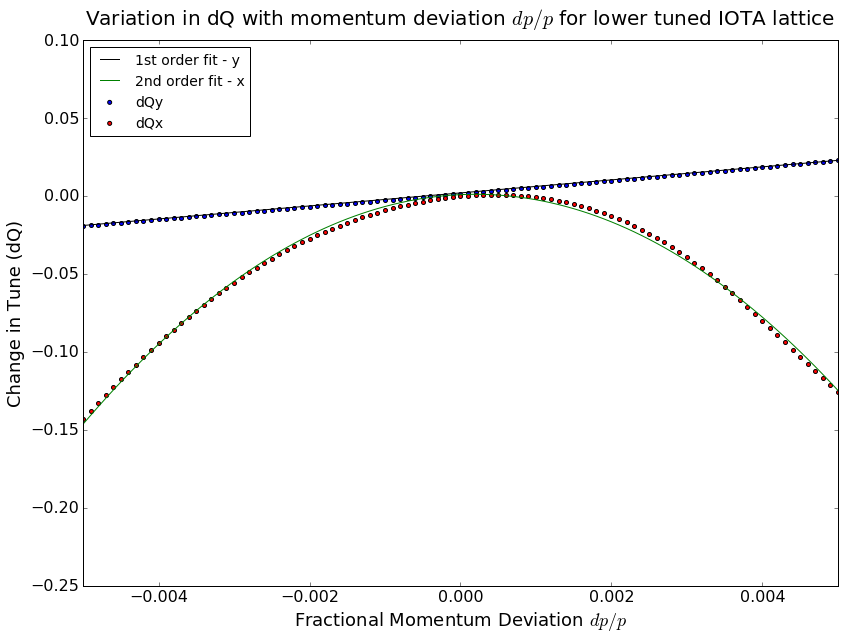

In [92]:
fitted_poly1y = poly1(opts.dpops[50:151], popty1[0],popty1[1])
fitted_poly3y = poly3(opts.dpops[50:151], popty[0],popty[1],popty[2],popty[3])

mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 

fig = plt.figure(figsize=(12,9))
ax = fig.gca()
ax.scatter(opts.dpops,dQy, s=16, c='b', label = 'dQy')
ax.plot(opts.dpops[50:151],fitted_poly1y,'k', label = '1st order fit - y')
ax.scatter(opts.dpops,dQx, s=16,c = 'r', label = 'dQx')
ax.plot(opts.dpops[50:151],p_poly2x,'g', label = '2nd order fit - x')
ax.set_xlim([-0.005,0.005])
ax.set_xlabel('Fractional Momentum Deviation $dp/p$', fontsize=18)
ax.set_ylabel('Change in Tune (dQ)', fontsize=18)
ax.set_title('Variation in dQ with momentum deviation $dp/p$ for lower tuned IOTA lattice', fontsize=20, y=1.02)
ax.legend(scatterpoints=1, loc=2, fontsize=14)
fig.savefig('newlattice_2ndorderx-nonlinear_chromaticity_fits.pdf')
plt.show()